## Libraries

In [1]:
import tempfile
import math
import os
from subprocess import call
import matplotlib.pyplot as plt
from f90nml import *
from array import *
import numpy as np
import pandas as pd 
import seaborn as sns
import importlib as im
from statistics import *
import shutil
import sys
import time
from numpy import mean
from numpy import std
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import linregress
from importlib import reload

#read in printFolder, makeDefNameList, newFolder, deleteFolder, readOutput from coreFunctions.py
from coreFunctions import *

#read in plotting functionality from plottingFunctions.py
from plottingFunctions import *

call("rm -rf tmp*",shell=True)

dfModel = []#will contain output from our model

## Run the Coupled Model

seasons :  True
snowball :  False
tend :  31540000.0
dt :  86400.0
rot :  7.27e-05
a :  14959789200000.0
ecc :  0.0167
peri :  76.25
obl :  23.5
cloudir :  -9.5
pco20 :  0.00028399999999999996
ocean :  0.7
igeog :  1
groundalb :  0.291
relsolcon :  1.0
landsnowfrac :  1.0
fcloud :  0.5
d0 :  0.58
N0 :  82.28928799193567
Nmax :  10000
rBirth0 :  0.04
rBirthMax :  0.83
rDeath0 :  0.036
rTech :  1.0
opT :  290.5
rco2 :  0.000275
En0 :  1.0
fragility :  1.0
coupled :  True
lverbose :  False
runTime :  3000
dtemp :  5
dpco2 :  0.0002
dPower :  1.0


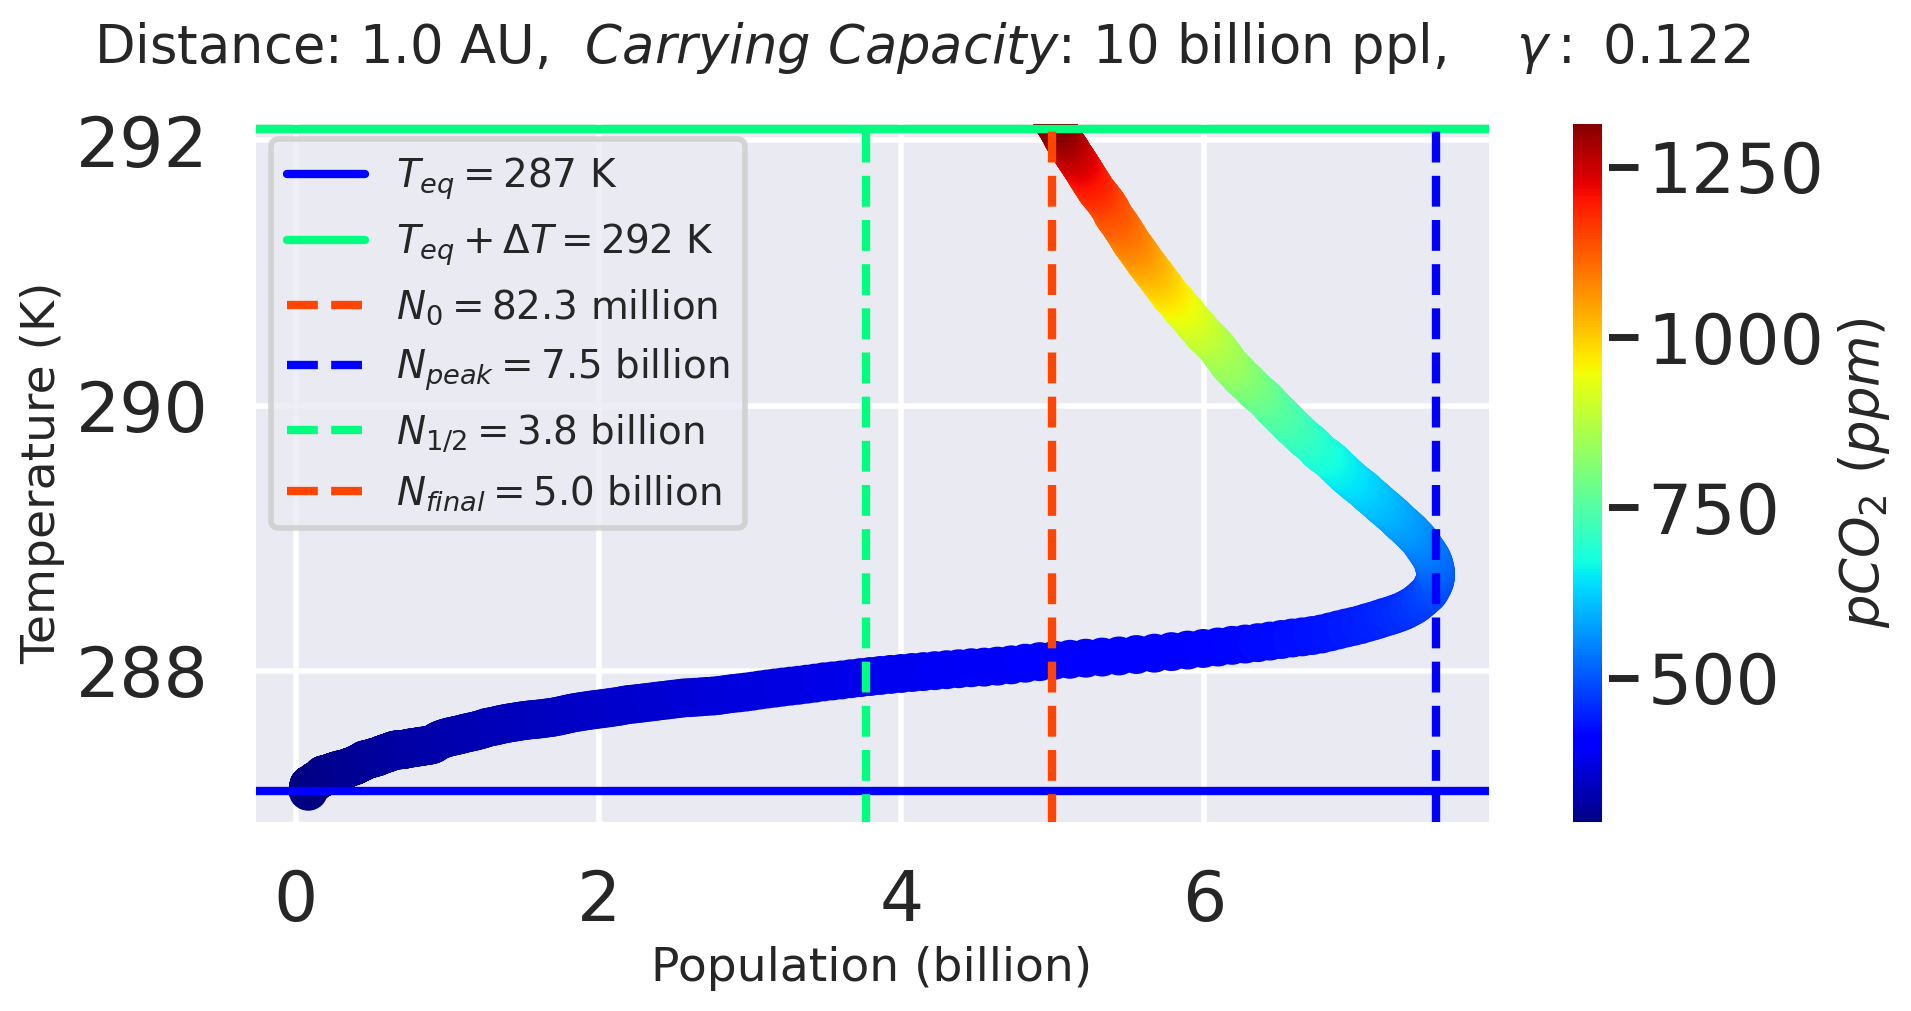

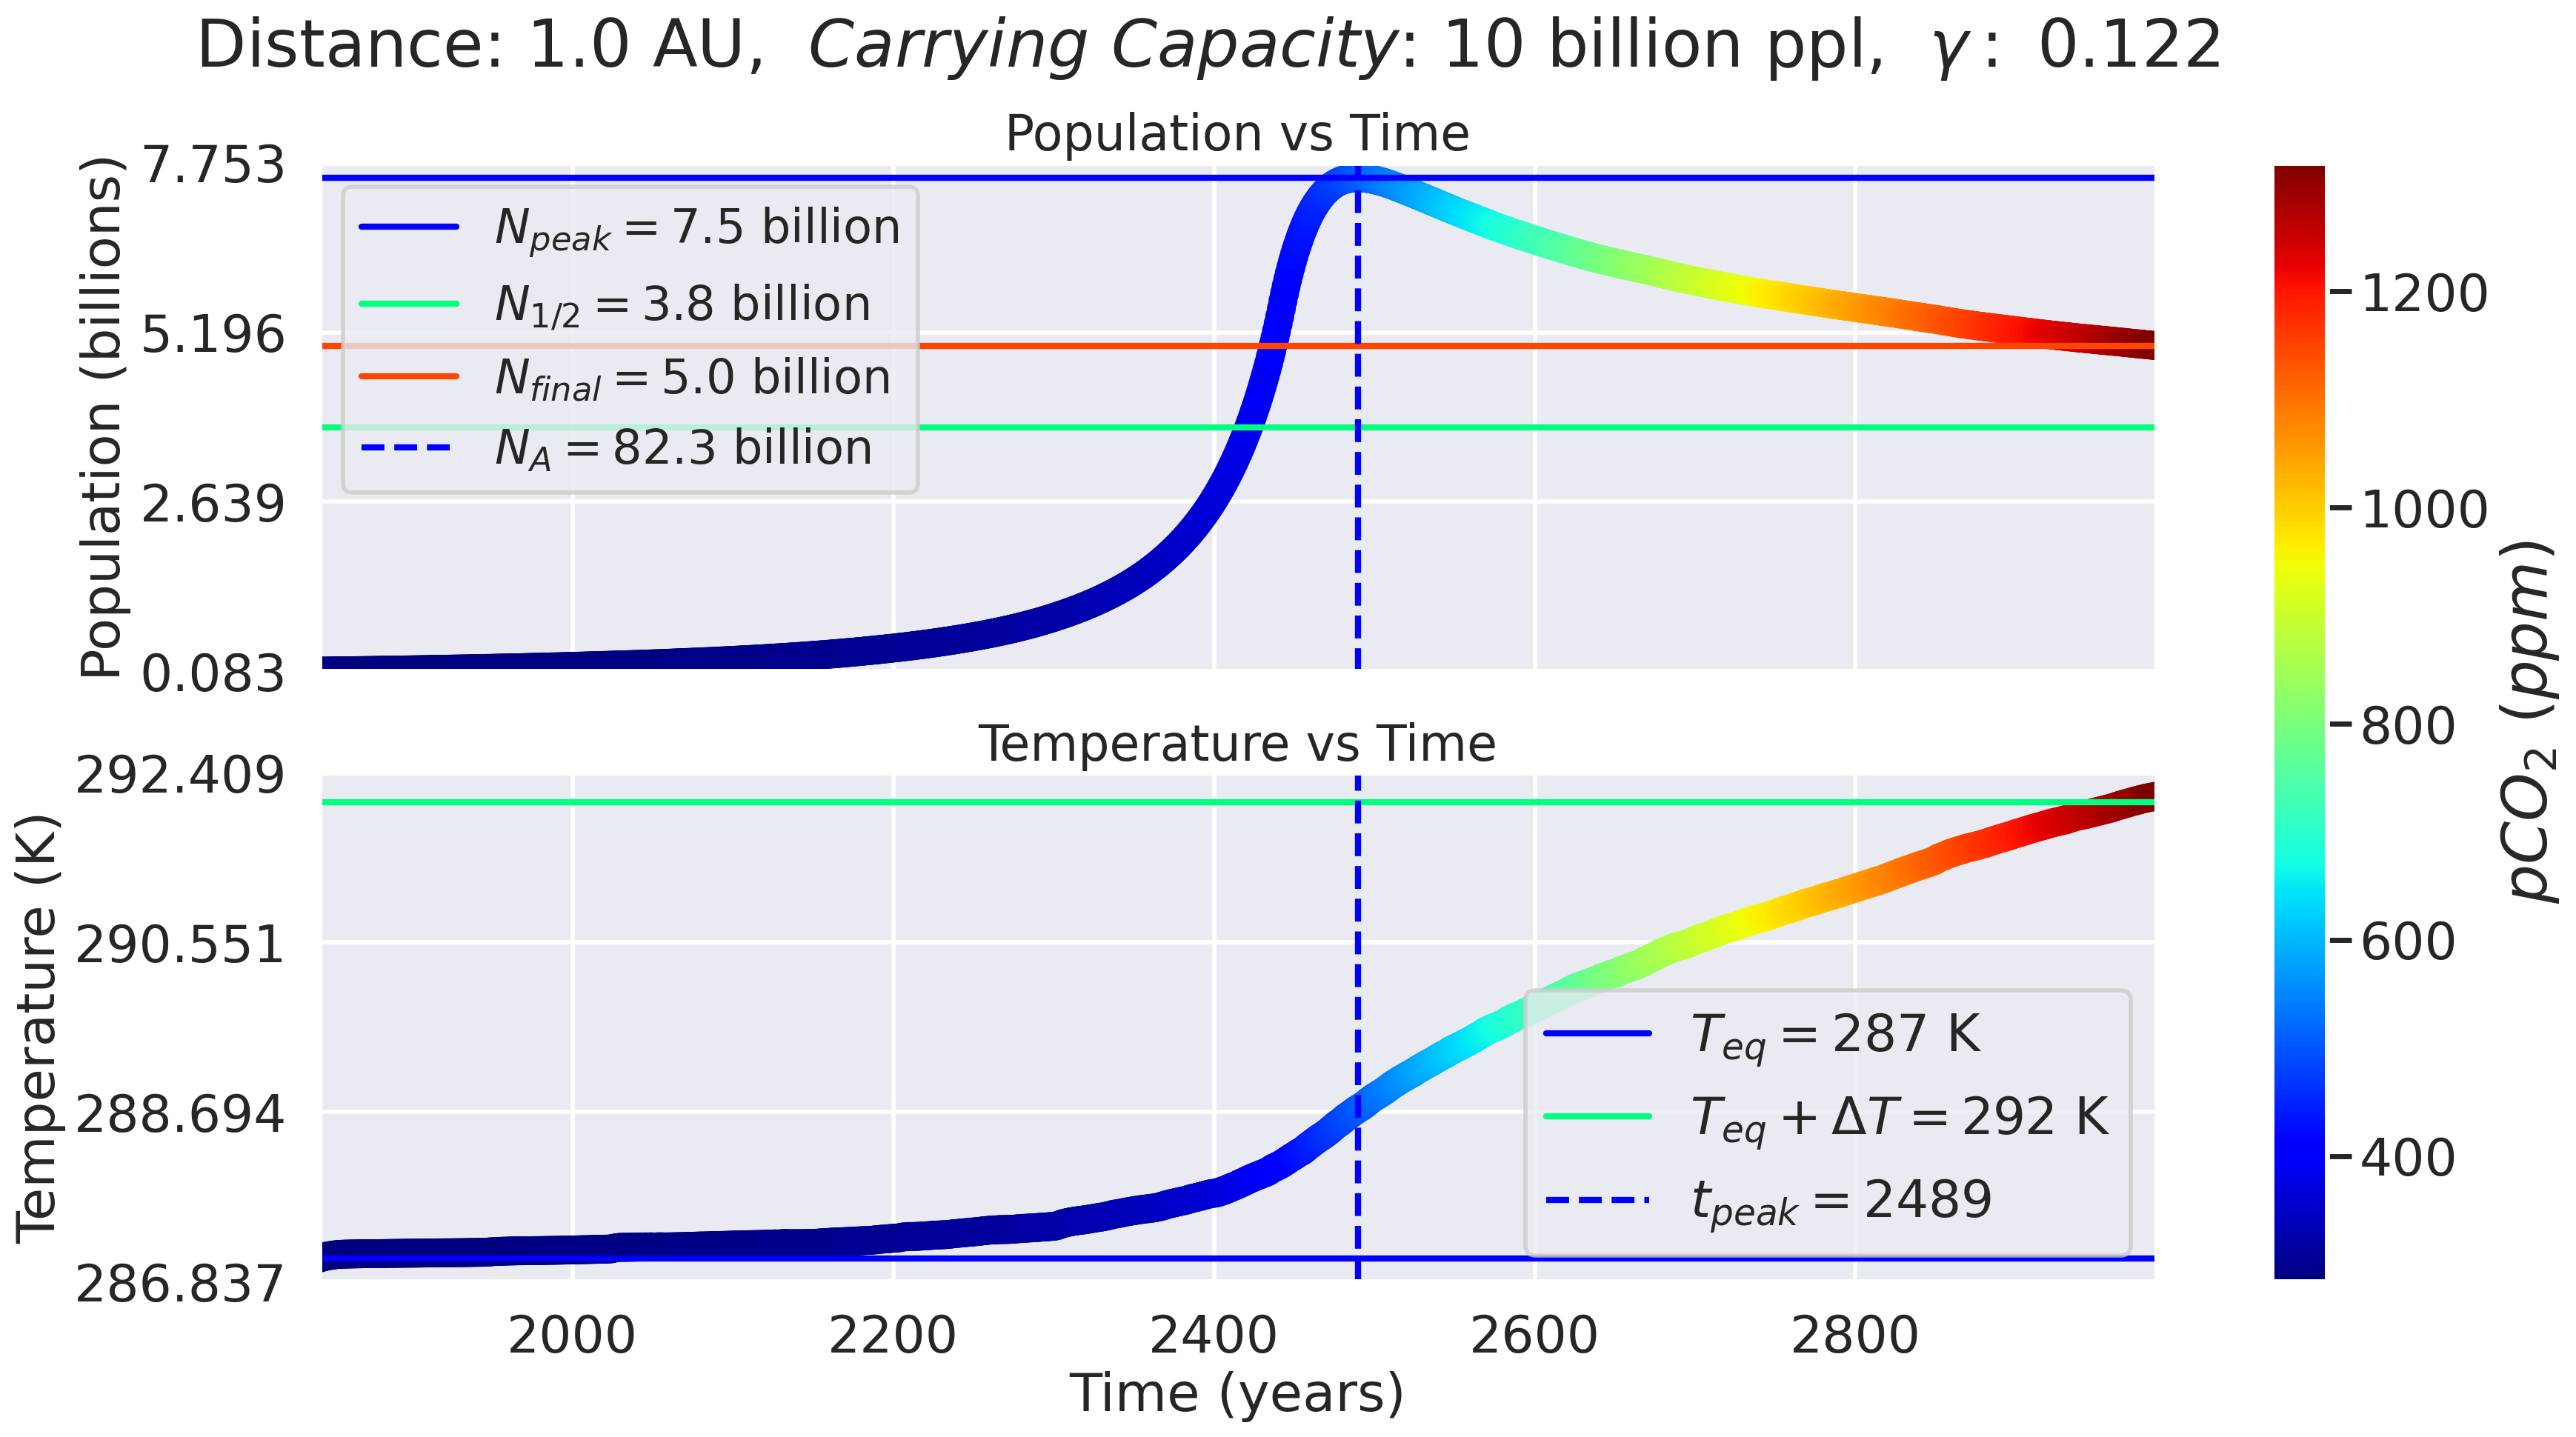

7.027010440826416


In [15]:
start = time.time()
nameList = makeDefNamelist() #make namelist
#-------------------------------------Boolean Inputs--------------------------------------------------
plot=True;#make the fancy plots?
save = False;
show = True;
coupled=True;
analyze = True #whether or not to analyze the population parts of model
lverbose=False #controls terminal output, used for debugging
showInputs = True #prints the namelist before running the program
exp =1
runTime=3000                          #Change runtime           (years)
#-------------------------------------Other Important Inputs-------------------------------------------------# maxPopList = [10000,40000,70000,100000] #specify all maxpops to use
distList= [1] #specify all distances to use
maxPopList = [10000]
pco20 =  284
deathPower = 1.00
#----------------------------------Set NameList Values to Specified Inputs---------------------
nameList['ebm']['lverbose'] = lverbose
nameList['ebm']['pco20'] = pco20*10**-6
nameList['ebm']['dPower'] = deathPower
#------------------------------------Run the Model----------------------------------------------------
dfModel,dfData,eq, eqTemp, eqTime, popDeath = runModel(nameList, coupled, runTime, plot, [save,show], analyze, "driver.exe", maxPopList, distList, showInputs, experiment=1, analyzeVerbose=False, scaleInitPop=True)
end = time.time()
print(end-start)
#print(popDeath)#number of people that have died in the time range of 2 generations after peak
#finalTemp = dfModel['temp'][dfModel.index[-1]] #find final temperature
#------------------------------------Plot the Results----------------------------------------------
#dfTemp = pd.read_csv('anomaly.csv');#data from NASA GISS: https://data.giss.nasa.gov/gistemp/graphs_v4/
#dfPopCo2 = pd.read_csv('world_stats.csv');#data from Frank, Adam, and Woodruff Sullivan.
#compareModelOutput(dfModel,dfTemp,dfPopCo2,eqTime)#compare the models output to true data
#call("echo End of Python Notebook Reached", shell=True);

In [ ]:
for i in ['10']:
    print(i)

## Run The Experiments

In [ ]:
nameList = makeDefNamelist() #make namelist

#-------------------------------------Experiment #1-------------------------------------------------
#minD, maxD = habitableZoneFinder_exp1(nameList, False) #lverbose=False, printOutput=False
#print(f"Max: {maxD}, Min: {minD}")
# distLin= np.linspace(.94,1.02,5) #specify all distances to use, linearly spaced
# dictData_exp1 = regionSweep(distLin, nameList, verbose=False, exp=1)
# linearRegressions(dictData_exp1, distLin, plotSlopes=True, plotData=True, saveName="exp1")

#-------------------------------------Experiment #2----------------------------------------------------
# #minD, maxD = habitableZoneFinder_exp2(nameList, lverbose=True)
# #print(f"Max: {maxD}, Min: {minD}")
distances = np.round(np.linspace(0.975, 1.105, 5),4)
#distances = np.asarray([0.975, 1.04])
# #distances=np.asarray([0.975])
# # for i in distances:
# #     pc02 = pco2Finder(287.09, nameList, i, lverbose=True)
# #     print(f"Distance: {i:.4f} AU,  pCO20={pc02}")
#dictData_exp2 = regionSweep(distances, nameList, verbose=False, exp=2)
#linearRegressions(dictData_exp2, distances, plotSlopes=True, plotData=True, saveName="exp2")

## Make Plots for Experiments

In [ ]:
# start = time.time()
# nameList = makeDefNamelist() #make namelist
# #-------------------------------------Boolean Inputs------------------------------------------------#
# plot=True;#make the fancy plots?
# save=True#save the plots
# coupled=True;
# analyze = True #whether or not to analyze the population parts of model
# lverbose=False #controls terminal output, used for debugging
# showInputs = False #prints the namelist before running the program
# save = True
# show = False
# runTime=4000 #Change runtime(years)
# #-------------------------------------Experiment #1-------------------------------------------------# 
# exp=1
# distList= np.round(np.linspace(0.94, 1.02, 5),4) #specify all distances to use
# maxPopList = [10000, 40000, 70000, 100000]
# # distList = [0.94]
# # maxPopList = [10000]
# pco20 =  284
# nameList['ebm']['lverbose'] = lverbose
# nameList['ebm']['pco20'] = pco20*10**-6
# dfModel,dfData,eqList_exp1, eqTempList_exp1, eqTimeList_exp1, popDeathList_exp1 = runModel(nameList, coupled, runTime, plot, [save,show], analyze,"driver.exe",maxPopList,distList,showInputs,experiment=exp, scaleInitPop=True)
# # #-------------------------------------Experiment #2-------------------------------------------------#
# exp=2
# distList= np.round(np.linspace(0.975, 1.105, 5),4) #specify all distances to use
# maxPopList = [10000, 40000, 70000, 100000]
# # distList = [0.975]
# # maxPopList = [10000]
# nameList['ebm']['lverbose'] = lverbose
# dfModel,dfData,eqList_exp2, eqTempList_exp2, eqTimeList_exp2, popDeathList_exp2 = runModel(nameList, coupled, runTime, plot, [save,show], analyze,"driver.exe",maxPopList,distList,showInputs,experiment=exp, scaleInitPop=True)
# #---------------------------------------------------------------------------------------------------#
# end = time.time()
# print(end-start)